In [10]:
import os
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, roc_auc_score,f1_score
from gurobipy import GRB

license_path = os.path.join("gurobi.lic")
os.environ["GRB_LICENSE_FILE"] = license_path
env = gp.Env(empty=True)
env.setParam('OutputFlag', 0)
env.start()

<gurobipy.Env, Parameter changes: OutputFlag=0>

## VRS for $\text{DMU}_r$
### Sets
$K$：公司集合  
$I$：投入資源種類集合  
$J$：產出集合  

### Parameters
$X_{ki}$：公司$k$投入資源$i$的總量  
$Y_{kj}$：公司$k$產出$j$的總量

### Decision variables
$\theta_r$：對公司$r$計算CRS的技術效率  
$\lambda_k$：對公司投入之間做線性組合時，公司$k$的權重  

### Objective
$\theta^{VRS*}_r = \min.~\theta_r$

### Constraints
$\displaystyle{\sum_{k \in K} \lambda_k X_{ki} \leq \theta_r X_{ri},~\forall i \in I}$  
$\displaystyle{\sum_{k \in K} \lambda_k Y_{kj} \geq Y_{rj},~\forall j \in J}$  
$\displaystyle{\sum_{k \in K} \lambda_k = 1}$  
$\lambda_k \geq 0,~\forall k \in K$

In [11]:
data = pd.read_csv(os.path.join("data", "faults.csv"))
data = data[(data["Bumps"] == 1) | (data['K_Scatch'] == 1)]
data = data.drop(['Pastry', 'Z_Scratch', 'Stains', 'Dirtiness', 'Other_Faults', 'K_Scatch'],axis=1).reset_index(drop=True)
data

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Bumps
0,464,474,28542,28553,72,13,12,13094,168,198,...,0.7692,0.9167,1.0,1.8573,1.0000,1.0414,0.0909,0.4208,0.2173,0
1,853,861,31984,31995,66,9,11,12872,178,207,...,0.8889,1.0000,1.0,1.8195,0.9031,1.0414,0.2727,0.5237,0.1934,0
2,0,9,35152,35164,61,10,12,10855,168,189,...,0.9000,1.0000,1.0,1.7853,0.9542,1.0792,0.2500,0.3902,0.2150,0
3,816,824,40184,40195,75,8,11,14016,157,206,...,1.0000,1.0000,1.0,1.8751,0.9031,1.0414,0.2727,0.4600,0.1934,0
4,827,843,48480,48539,443,56,60,79713,77,221,...,0.2857,0.9833,1.0,2.6464,1.2041,1.7708,0.7288,0.4058,0.9863,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,221,242,3948212,3948253,519,33,41,48309,65,124,...,0.6364,1.0000,1.0,2.7152,1.3222,1.6128,0.4878,-0.2728,0.9765,1
789,1111,1121,4032298,4032320,110,20,22,12351,100,127,...,0.5000,1.0000,1.0,2.0414,1.0000,1.3424,0.5454,-0.1228,0.3663,1
790,995,1006,4085316,4085344,140,25,28,16076,103,132,...,0.4400,1.0000,1.0,2.1461,1.0414,1.4472,0.6071,-0.1029,0.5096,1
791,396,418,4116853,4116868,231,26,16,25096,56,141,...,0.8461,0.9375,0.0,2.3636,1.3424,1.1761,-0.3182,-0.1512,0.5461,1


In [7]:
X = data.drop(['Bumps'],axis=1)
y = data['Bumps']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [8]:
max_estimators = 20
max_d = 13
max_size = 150

verbose = False

# roc_auc_estimators = list()
# recall_estimators = list()
# precision_estimators = list()
# f1_score_estimators = list()

hyper_to_metrics_dict = dict()

for n_estimators in tqdm.tqdm(range(1, max_estimators, 1)):
    for depth in range(1, max_d, 1):
        for size in range(10, max_size, 5):
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=depth, random_state=880203)
            clf.fit(X_train[:size],y_train[:size])

            y_pred = clf.predict(X_test)
            if verbose:
                print(confusion_matrix(y_test, y_pred))
                print("acc_score", accuracy_score(y_test, y_pred))
                print("precision", precision_score(y_test, y_pred))
                print("recall", recall_score(y_test, y_pred))
                print('roc_auc_score', roc_auc_score(y_test, y_pred))
            hyper_to_metrics_dict[(n_estimators, depth, size)] = (roc_auc_score(y_test, y_pred), 
                                         (recall_score(y_test, y_pred) * 10)**2, 
                                         (precision_score(y_test, y_pred) * 10)**2, 
                                         f1_score(y_test, y_pred))
            # roc_auc_estimators.append(roc_auc_score(y_test, y_pred))
            # recall_estimators.append(recall_score(y_test, y_pred))
            # precision_estimators.append(precision_score(y_test, y_pred))
            # f1_score_estimators.append(f1_score(y_test, y_pred))

# print("roc_auc")
# plt.scatter(range(1,max_estimators), roc_auc_estimators)
# plt.show()
# print("recall")
# plt.scatter(range(1,max_estimators), recall_estimators)
# plt.show()
# print("precision")
# plt.scatter(range(1,max_estimators), precision_estimators)
# plt.show()
# print("f1_score")
# plt.scatter(range(1,max_estimators), f1_score_estimators)
# plt.show()

100%|██████████| 19/19 [01:44<00:00,  5.49s/it]


In [9]:
# roc_auc_depth=[]
# recall_depth=[]
# precision_depth=[]
# f1_score_depth = []

# max_d = 31
# for depth in range(1,max_d):
#     clf = RandomForestClassifier(n_estimators=20,max_depth=depth, random_state=880203)
#     clf.fit(X_train,y_train)

#     y_pred = clf.predict(X_test)
#     if verbose:
#         print(confusion_matrix(y_test,y_pred))
#         print("acc_score ", accuracy_score(y_test, y_pred))
#         print("precision ", precision_score(y_test, y_pred))
#         print("recall ", recall_score(y_test, y_pred))
#         print('roc_auc_score ', roc_auc_score(y_test, y_pred))
#     roc_auc_depth.append(roc_auc_score(y_test, y_pred))
#     recall_depth.append(recall_score(y_test, y_pred))
#     precision_depth.append(precision_score(y_test,y_pred))
#     f1_score_depth.append(f1_score(y_test,y_pred))

# print("roc_auc")
# plt.scatter(range(1,max_d), roc_auc_depth)
# plt.show()
# print("recall")
# plt.scatter(range(1,max_d), recall_depth)
# plt.show()
# print("precision")
# plt.scatter(range(1,max_d), precision_depth)
# plt.show()
# print("f1_score")
# plt.scatter(range(1,max_d), f1_score_depth)
# plt.show()

In [10]:
# roc_auc_size=[]
# recall_size=[]
# precision_size=[]
# f1_score_size = []

# max_size = 501
# for size in range(10,max_size,5):
#     clf = RandomForestClassifier(n_estimators=20,max_depth=5, random_state=880203)
#     clf.fit(X_train[:size],y_train[:size])

#     y_pred = clf.predict(X_test)
#     if verbose:
#         print(confusion_matrix(y_test,y_pred))
#         print("acc_score ", accuracy_score(y_test, y_pred))
#         print("precision ", precision_score(y_test, y_pred))
#         print("recall ", recall_score(y_test, y_pred))
#         print('roc_auc_score ', roc_auc_score(y_test, y_pred))
#     roc_auc_size.append(roc_auc_score(y_test, y_pred))
#     recall_size.append(recall_score(y_test, y_pred))
#     precision_size.append(precision_score(y_test,y_pred))
#     f1_score_size.append(f1_score(y_test, y_pred))

# print("roc_auc")
# plt.scatter(range(10,max_size,5), roc_auc_size)
# plt.show()
# print("recall")
# plt.scatter(range(10,max_size,5), recall_size)
# plt.show()
# print("precision")
# plt.scatter(range(10,max_size,5), precision_size)
# plt.show()
# print("f1_score")
# plt.scatter(range(10,max_size,5), f1_score_size)
# plt.show()

## VRS for $\text{DMU}_r$
### Sets
$K$：模型集合  
$I$：超參數種類集合  
$J$：指標集合  

### Parameters
$X_{ki}$：模型$k$超參數$i$設定值
$Y_{kj}$：模型$k$評估指標$j$

### Decision variables
$\theta_r$：對公司$r$計算CRS的技術效率  
$\lambda_k$：對公司投入之間做線性組合時，公司$k$的權重  

### Objective
$\theta^{VRS*}_r = \min.~\theta_r$

### Constraints
$\displaystyle{\sum_{k \in K} \lambda_k X_{ki} \leq \theta_r X_{ri},~\forall i \in I}$  
$\displaystyle{\sum_{k \in K} \lambda_k Y_{kj} \geq Y_{rj},~\forall j \in J}$  
$\displaystyle{\sum_{k \in K} \lambda_k = 1}$  
$\lambda_k \geq 0,~\forall k \in K$

In [11]:
K = hyper_to_metrics_dict.keys()
I = range(3)
J = [1,2]
# J = range(2)



VRS_models = dict()
for r in tqdm.tqdm(K):
    m = gp.Model(f"VRS-{r}", env=env)
    theta = m.addVar(vtype=GRB.CONTINUOUS, lb=0)
    lambda_ = m.addVars(K, vtype=GRB.CONTINUOUS, lb=0)
    m.setObjective(theta)
    for i in I:
        m.addConstr(
            gp.quicksum(lambda_[k] * k[i] for k in K) <= theta * r[i]
        )
    for j in J:
        m.addConstr(
            gp.quicksum(lambda_[k] * hyper_to_metrics_dict[k][j] for k in K) >= hyper_to_metrics_dict[r][j]
        )
    m.addConstr(
        gp.quicksum(lambda_[k] for k in K) == 1
    )
    m.optimize()
    VRS_models[r] = m

100%|██████████| 6384/6384 [10:04<00:00, 10.56it/s]  


In [12]:
print("TE:")
for r in VRS_models:
    print(f"{r}:", VRS_models[r].ObjVal)

TE:
(1, 1, 10): 1.0
(1, 1, 15): 1.0
(1, 1, 20): 1.0
(1, 1, 25): 1.0
(1, 1, 30): 1.0
(1, 1, 35): 1.0
(1, 1, 40): 1.0
(1, 1, 45): 1.0
(1, 1, 50): 1.0
(1, 1, 55): 1.0
(1, 1, 60): 1.0
(1, 1, 65): 1.0
(1, 1, 70): 1.0
(1, 1, 75): 1.0
(1, 1, 80): 1.0
(1, 1, 85): 1.0
(1, 1, 90): 1.0
(1, 1, 95): 1.0
(1, 1, 100): 1.0
(1, 1, 105): 1.0
(1, 1, 110): 1.0
(1, 1, 115): 1.0
(1, 1, 120): 1.0
(1, 1, 125): 1.0
(1, 1, 130): 1.0
(1, 1, 135): 1.0
(1, 1, 140): 1.0
(1, 1, 145): 1.0
(1, 2, 10): 1.0
(1, 2, 15): 1.0
(1, 2, 20): 1.0
(1, 2, 25): 1.0
(1, 2, 30): 1.0
(1, 2, 35): 1.0
(1, 2, 40): 1.0
(1, 2, 45): 1.0
(1, 2, 50): 1.0
(1, 2, 55): 1.0
(1, 2, 60): 1.0
(1, 2, 65): 1.0
(1, 2, 70): 1.0
(1, 2, 75): 1.0
(1, 2, 80): 1.0
(1, 2, 85): 1.0
(1, 2, 90): 1.0
(1, 2, 95): 1.0
(1, 2, 100): 1.0
(1, 2, 105): 1.0
(1, 2, 110): 1.0
(1, 2, 115): 1.0
(1, 2, 120): 1.0
(1, 2, 125): 1.0
(1, 2, 130): 1.0
(1, 2, 135): 1.0
(1, 2, 140): 1.0
(1, 2, 145): 1.0
(1, 3, 10): 1.0
(1, 3, 15): 1.0
(1, 3, 20): 1.0
(1, 3, 25): 1.0
(1, 3, 30): 1.0


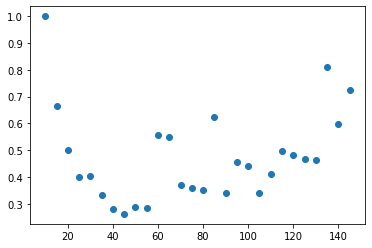

In [18]:
plt.scatter([r[2] for r in VRS_models if r[0]==8 and r[1]==5], [VRS_models[r].ObjVal for r in VRS_models if r[0]==8 and r[1]==5])

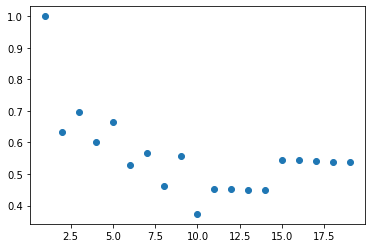

In [19]:
plt.scatter([r[0] for r in VRS_models if r[1]==8 and r[2]==130], [VRS_models[r].ObjVal for r in VRS_models if r[1]==8 and r[2]==130])

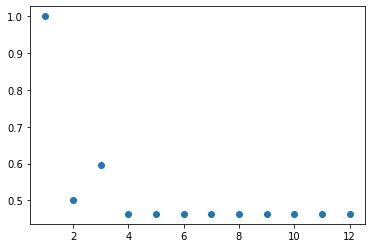

In [20]:
plt.scatter([r[1] for r in VRS_models if r[0]==8 and r[2]==130], [VRS_models[r].ObjVal for r in VRS_models if r[0]==8 and r[2]==130])